aqui cargamos los datos raw y los entendemos, visualizamos, mostramos estadisticas descriptivas, verificamos el balance de la variable objetivo, etc.

In [1]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import nltk     
import re
import string
import spacy
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import graphviz 
from sklearn import tree
from sklearn import metrics
from wordcloud import WordCloud
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from pathlib import Path

DATA_DIR = os.path.join( '..', 'data')
RAW_DATA_DIR = os.path.join(DATA_DIR, 'raw')
PROCESSED_DATA_DIR = os.path.join(DATA_DIR, 'processed')



In [2]:

file_path=os.path.join(RAW_DATA_DIR,"SMSSpamCollection")

# Utiliza \t como delimitador
sms = pd.read_csv(file_path, sep="\t", header=None, names=["Label", "SMS"])
sms.head()


,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
sms.shape

(5572, 2)

In [4]:
sms.Label.value_counts()

Label
ham     4825
spam     747
Name: count, dtype: int64

In [5]:
#check for missing values
sms.isnull().sum()

Label    0
SMS      0
dtype: int64

In [6]:
sms.duplicated(subset="SMS",keep="first").sum()



403

In [7]:
sms[sms.duplicated(subset="SMS",keep=False)].sort_values(by="SMS")

,Label,SMS
505,spam,+123 Congratulations - in this week's competit...
2124,spam,+123 Congratulations - in this week's competit...
2344,ham,1) Go to write msg 2) Put on Dictionary mode 3...
1373,ham,1) Go to write msg 2) Put on Dictionary mode 3...
2163,ham,1) Go to write msg 2) Put on Dictionary mode 3...
...,...,...
1381,ham,i dnt wnt to tlk wid u
1412,ham,somewhere out there beneath the pale moon ligh...
4004,ham,somewhere out there beneath the pale moon ligh...
2389,ham,wiskey Brandy Rum Gin Beer Vodka Scotch Shampa...


In [8]:


# Assuming 'sms' is your DataFrame
sms = sms[~(sms.duplicated(subset=['SMS']) & (sms['Label'] == 'ham'))].reset_index(drop=True)

# Print the shape of the resulting DataFrame
print(sms.shape)


(5263, 2)


In [9]:
#drop duplicates with the same SMS in the label ham


In [10]:
# #drop duplicates in the column SMS
# sms=sms.drop_duplicates(subset=['SMS'], keep='first').reset_index(drop=True)
# sms.shape


In [11]:
sms['lenght'] = sms['SMS'].apply(len)

In [12]:
sms['Label'] = sms['Label'].map({'ham': 0, 'spam': 1})
sms.head()

,Label,SMS,lenght
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [13]:
sms['SMS'] = sms['SMS'].str.lower()

In [14]:
def transformations(transformations):
    if transformations == "NA":
        return "NA"
    else:
      transformations = re.sub(r'\b(u)\b','you', transformations)
      transformations = re.sub(r'\b(2)\b', 'to',transformations)
      transformations = re.sub(r'\b(i\' m)\b', 'i am', transformations)
      transformations = re.sub(r'\b(cant)\b', 'can not', transformations)
      transformations = re.sub(r'\b(thats)\b', 'that is', transformations)
      transformations = re.sub(r'\b(im)\b', 'i am', transformations)
      transformations = re.sub(r'\b(ill)\b', 'i will', transformations)
      transformations = re.sub(r'\b(ur)\b', 'your', transformations)
      transformations = re.sub(r'\b(4)\b', 'for', transformations)
      transformations = re.sub(r'\b(n)\b', 'no', transformations)
      transformations = re.sub(r'\b(i\'ll)\b', 'i will', transformations)
      transformations = re.sub(r'\b(ü)\b', 'you', transformations)
      transformations = re.sub(r'\b(&)\b', 'and', transformations)
      transformations = re.sub(r'\b(txt)\b', 'text', transformations)
      transformations = re.sub(r'\b(1)\b', 'one', transformations)
      transformations = re.sub(r'\b(po)\b', 'purchase order', transformations)
      transformations = re.sub(r'\b(dont)\b', 'do not', transformations)
      transformations = re.sub(r'\b(don\'t)\b', 'do not', transformations)
      transformations = re.sub(r'\b(lor)\b', 'lot', transformations)
      transformations = re.sub(r'\b(msg)\b', 'message', transformations)
      transformations = re.sub(r'\b(wat)\b', 'what', transformations)
      transformations = re.sub(r'\b(na)\b', 'not available', transformations)
      transformations = re.sub(r'\b(pls)\b', 'please', transformations)
      transformations = re.sub(r'\b(wkly)\b', 'weekly', transformations)
      transformations = re.sub(r'\b(i\'d)\b', 'i would', transformations)
      transformations = re.sub(r'\b(2nd)\b', 'second', transformations)
      transformations = re.sub(r'\b(usf)\b', 'university of south florida', transformations)
      transformations = re.sub(r'\b(hor)\b', 'hour', transformations)
      transformations = re.sub(r'\b(fr)\b', 'for', transformations)
      transformations = re.sub(r'\b(gt)\b', 'get', transformations)
      transformations = re.sub(r'\b(lt)\b', 'let', transformations)
      transformations = re.sub(r'\b(comp)\b', 'composition', transformations)
      transformations = re.sub(r'\b(go)\b', 'gone', transformations)
      transformations = re.sub(r'\b(wan)\b', 'want', transformations)
      transformations = re.sub(r'\b(mob)\b', 'mobile', transformations)
      transformations = re.sub(r'\b(\'s)\b', 'is', transformations)
      transformations = re.sub(r'\b(m)\b', 'i am', transformations)
      transformations = re.sub(r'\b(ll)\b', 'will', transformations)
      transformations = re.sub(r'\b(its)\b', 'it is', transformations)
      transformations = re.sub(r'\b(itis)\b', 'it is', transformations)
      transformations = re.sub(r'\b(i\'i)\b', 'i', transformations)
      transformations = re.sub(r'\b(cos)\b', 'because', transformations)





    return transformations

# Aplicar la función a la columna 'SMS' y sobrescribir el resultado
sms['SMS'] = sms['SMS'].apply(transformations)

In [15]:
# Palabras a eliminar
words_to_remove = ["&let;#&get;", "&amp;"]

# Reemplazar las palabras en la columna 'SMS'
sms['SMS'] = sms['SMS'].replace(words_to_remove, '', regex=True)

# Visualizar el DataFrame resultante
print(sms)

      Label                                                SMS  lenght
0         0  gone until jurong point, crazy.. available onl...     111
1         0                    ok lar... joking wif you oni...      29
2         1  free entry in to a weekly composition to win f...     155
3         0  you dun say so early hour... you c already the...      49
4         0  nah i do not think he goes to university of so...      61
...     ...                                                ...     ...
5258      1  this is the second time we have tried to conta...     160
5259      0            will you b going to esplanade for home?      36
5260      0  pity, * was in mood for that. so...any other s...      57
5261      0  the guy did some bitching but i acted like i w...     125
5262      0                     rofl. it is true to it is name      26

[5263 rows x 3 columns]


In [16]:
# Tokeniza el texto en la columna 'SMS' y agrega los tokens a una nueva columna 'Tokens'
sms['Tokens'] = sms['SMS'].apply(word_tokenize)

# Visualiza los primeros registros del DataFrame con los tokens
print(sms.head())

   Label                                                SMS  lenght  \
0      0  gone until jurong point, crazy.. available onl...     111   
1      0                    ok lar... joking wif you oni...      29   
2      1  free entry in to a weekly composition to win f...     155   
3      0  you dun say so early hour... you c already the...      49   
4      0  nah i do not think he goes to university of so...      61   

                                              Tokens  
0  [gone, until, jurong, point, ,, crazy, .., ava...  
1         [ok, lar, ..., joking, wif, you, oni, ...]  
2  [free, entry, in, to, a, weekly, composition, ...  
3  [you, dun, say, so, early, hour, ..., you, c, ...  
4  [nah, i, do, not, think, he, goes, to, univers...  


In [17]:
# Tokeniza el texto en la columna 'SMS' y agrega los tokens a una nueva columna 'Tokens'
sms['Tokens'] = sms['SMS'].apply(word_tokenize)

# Visualiza los primeros registros del DataFrame con los tokens
print(sms.head())

   Label                                                SMS  lenght  \
0      0  gone until jurong point, crazy.. available onl...     111   
1      0                    ok lar... joking wif you oni...      29   
2      1  free entry in to a weekly composition to win f...     155   
3      0  you dun say so early hour... you c already the...      49   
4      0  nah i do not think he goes to university of so...      61   

                                              Tokens  
0  [gone, until, jurong, point, ,, crazy, .., ava...  
1         [ok, lar, ..., joking, wif, you, oni, ...]  
2  [free, entry, in, to, a, weekly, composition, ...  
3  [you, dun, say, so, early, hour, ..., you, c, ...  
4  [nah, i, do, not, think, he, goes, to, univers...  


In [18]:
#Define una función para realizar la lematización. Esta función tomará una lista de palabras y las lematizará. Además, se necesita una función para asignar las etiquetas de parte de habla (POS) antes de la lematización. Las etiquetas POS son necesarias para que el proceso de lematización sea más preciso.

def get_wordnet_pos(word):
    """Mapea las etiquetas POS de NLTK a etiquetas de WordNet."""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_words(words):
    """Realiza la lematización de una lista de palabras."""
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]

#Carga tus datos en un DataFrame de Pandas.

#Aplica la lematización a la columna que contiene el texto. A continuación, se muestra cómo hacerlo:

sms['lemmatized_text'] = sms['SMS'].apply(lambda x: lemmatize_words(nltk.word_tokenize(x)))
#Donde df es tu DataFrame, 'text_column' es la columna que contiene el texto que deseas lematizar, y 'lemmatized_text' es la columna en la que se almacenarán los resultados de la lematización.

#Con estos pasos, habrás realizado la lematización de tu texto en Pandas utilizando NLTK. Recuerda ajustar las etiquetas POS según tus necesidades, ya que pueden variar según el contexto de tu texto.


In [19]:
# Descargar las stopwords en inglés si no están descargadas
nltk.download('stopwords')

# Obtener las stopwords en inglés
stop_words = set(stopwords.words('english'))

# Definir una función para remover stopwords
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Aplicar la función a la columna 'SMS' y crear una nueva columna 'SMS_without_stopwords'
sms['SMS_without_stopwords'] = sms['SMS'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lunai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
sms['processed_text'] = sms['SMS']

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lunai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


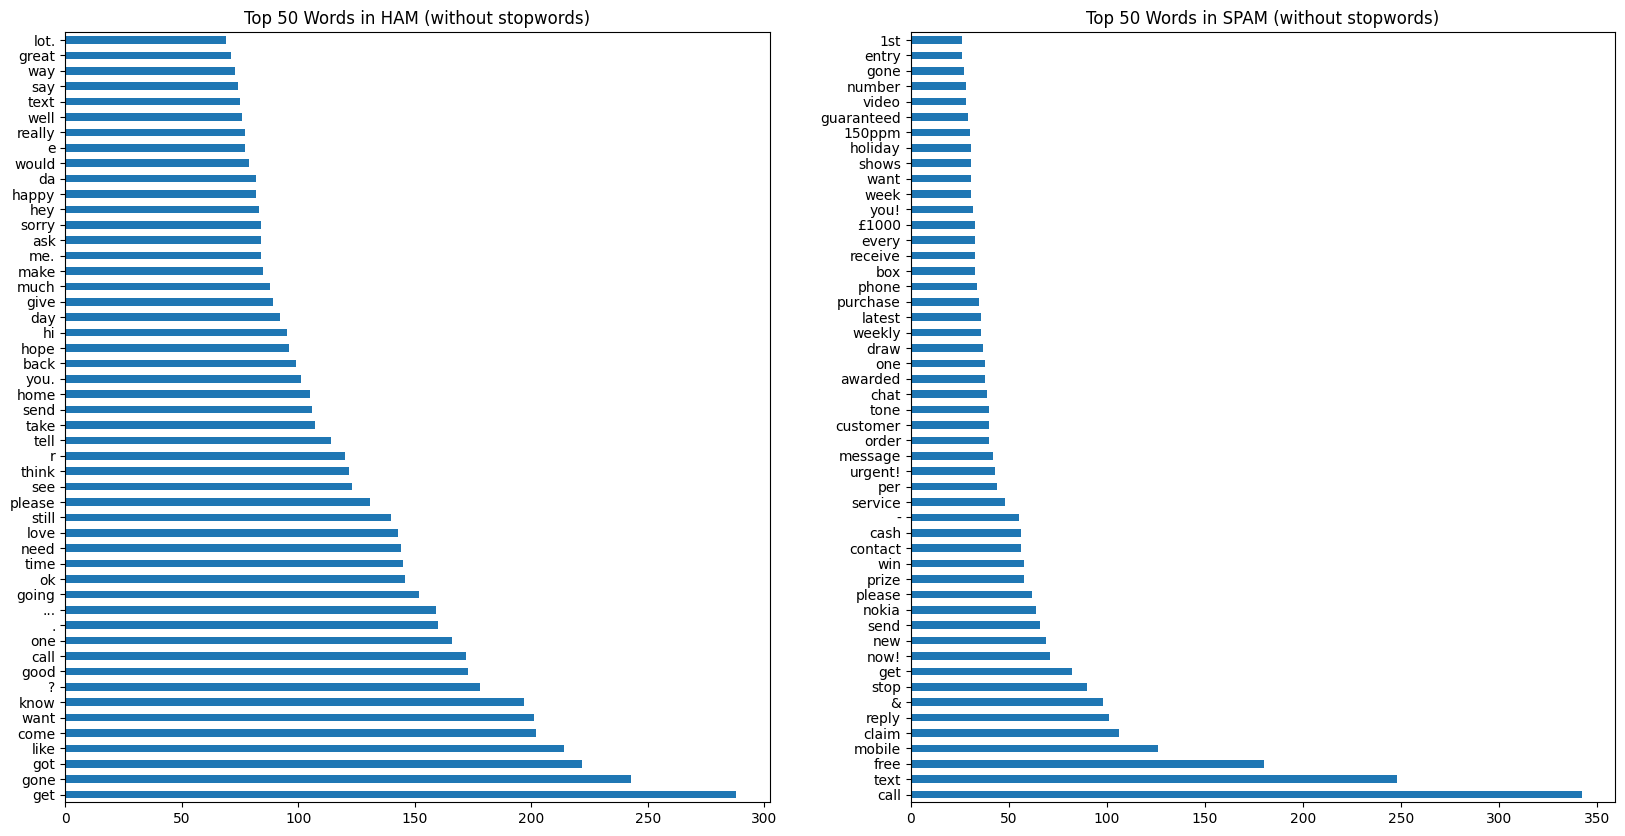

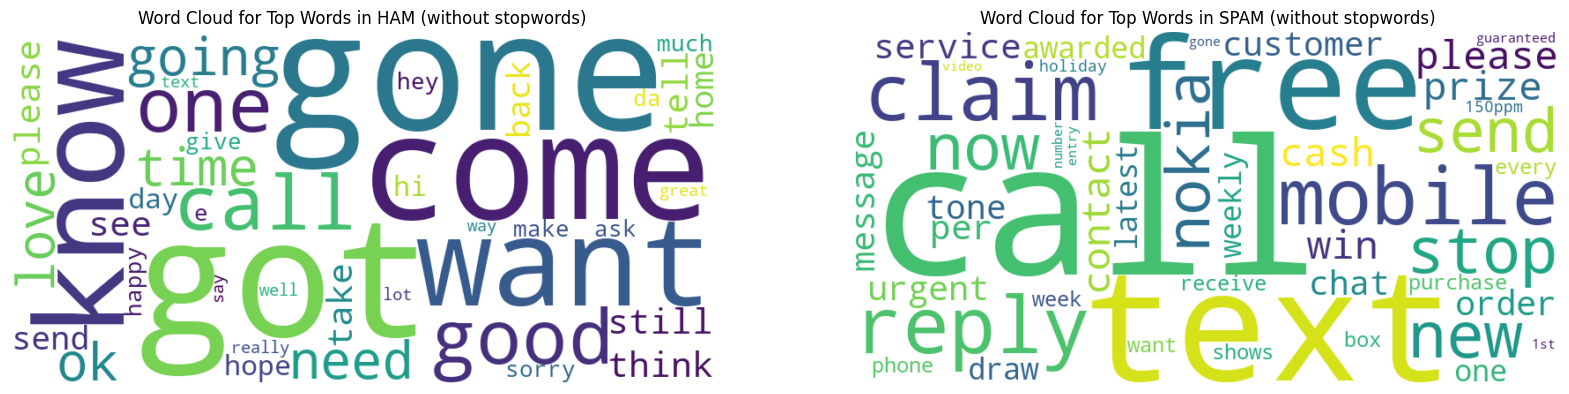

In [21]:
nltk.download('stopwords')

# Definir las stopwords en inglés
stop_words = set(stopwords.words('english'))

# Función para obtener las palabras más frecuentes excluyendo stopwords
def top_words(series, n=50):
    all_words = ' '.join(series).split()
    word_counts = pd.Series(all_words).value_counts()
    # Excluir stopwords
    word_counts = word_counts[~word_counts.index.isin(stop_words)]
    return word_counts.head(n)

# Realizar el gráfico de barras original
grouped = sms.groupby('Label')

ham_top_words = top_words(grouped.get_group(0)['processed_text'])
spam_top_words = top_words(grouped.get_group(1)['processed_text'])

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
ham_top_words.plot(kind='barh', ax=axes[0], title='Top 50 Words in HAM (without stopwords)')
spam_top_words.plot(kind='barh', ax=axes[1], title='Top 50 Words in SPAM (without stopwords)')

plt.show()

# Crear nubes de etiquetas basadas en las palabras más frecuentes sin stopwords
ham_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(ham_top_words.index))
spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(spam_top_words.index))

# Mostrar las nubes de etiquetas
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(ham_wordcloud, interpolation='bilinear')
axes[0].set_title('Word Cloud for Top Words in HAM (without stopwords)')
axes[0].axis('off')

axes[1].imshow(spam_wordcloud, interpolation='bilinear')
axes[1].set_title('Word Cloud for Top Words in SPAM (without stopwords)')
axes[1].axis('off')

plt.show()

C:\Users\lunai\AppData\Local\Temp\ipykernel_324\3938901792.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[0].text(v, i, f'{v} ({ham_percentages[i]:.2f}%)', color='black', va='center')
C:\Users\lunai\AppData\Local\Temp\ipykernel_324\3938901792.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[1].text(v, i, f'{v} ({spam_percentages[i]:.2f}%)', color='black', va='center')


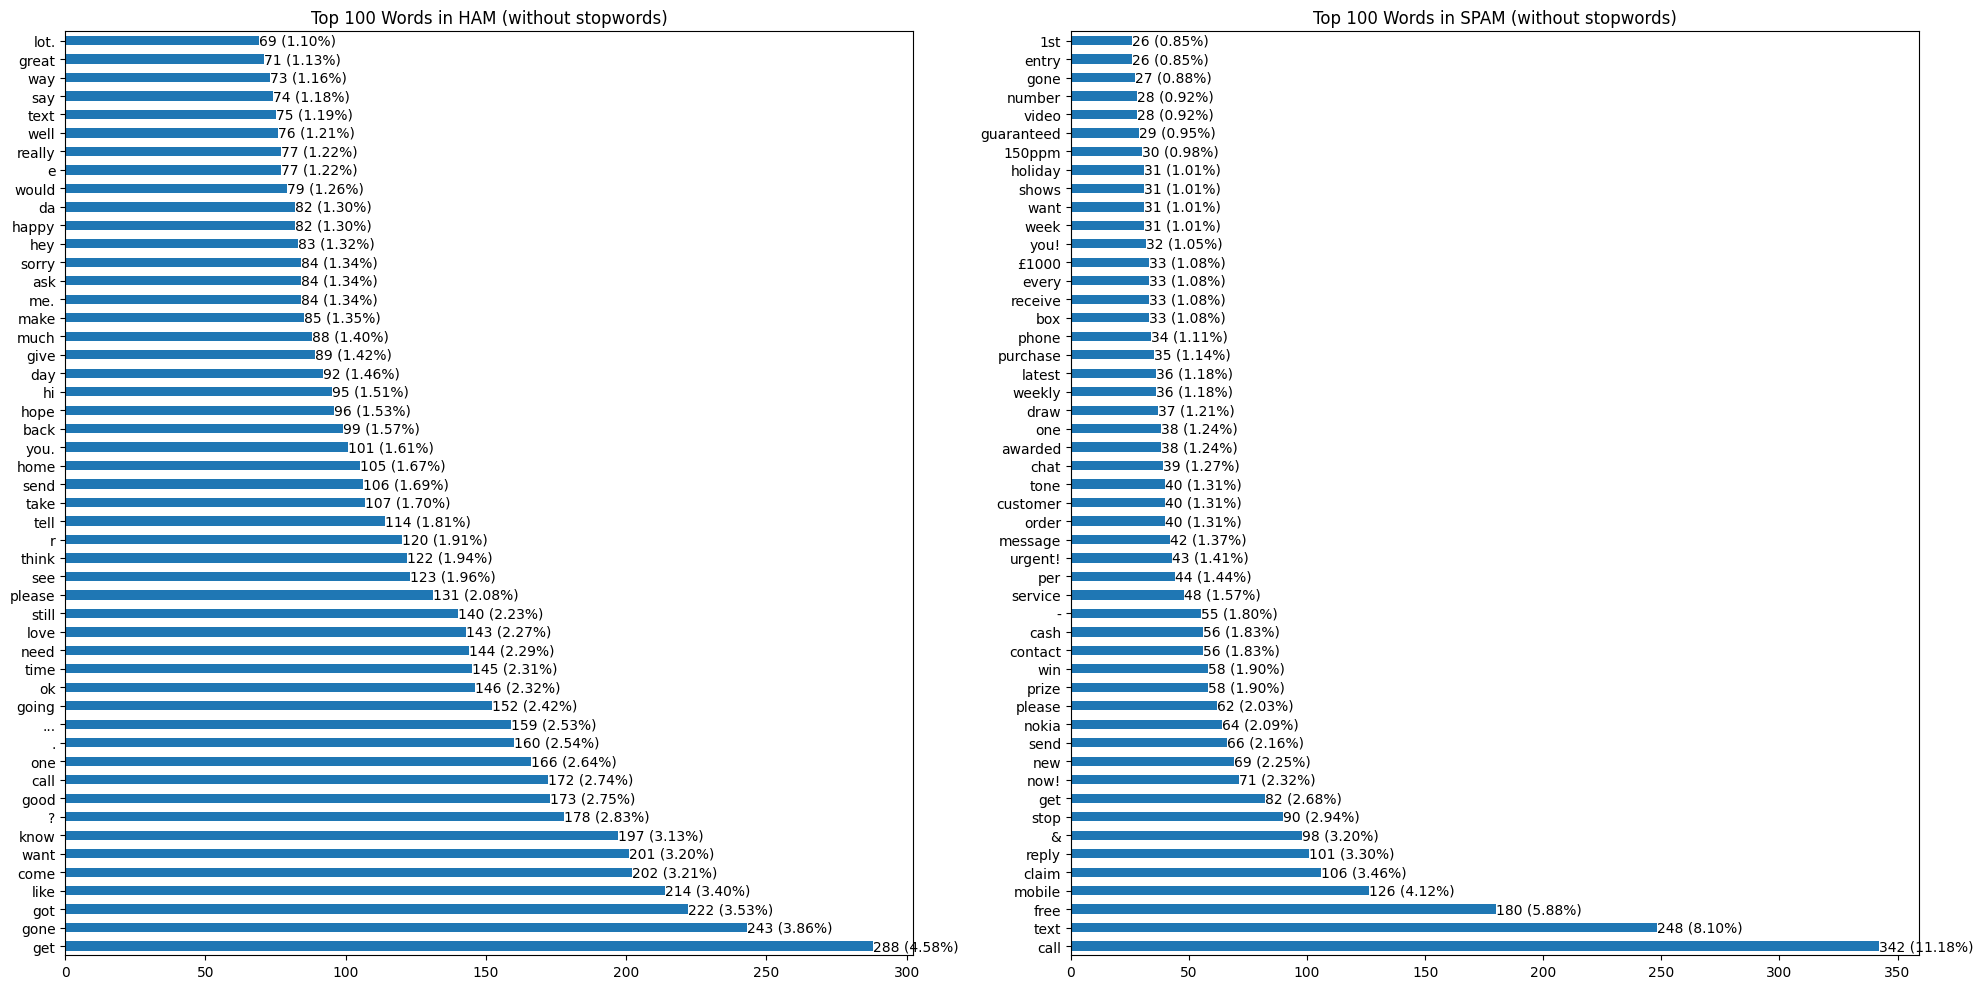

In [22]:
# Obtener el total de palabras en cada grupo (SPAM y HAM)
total_ham_words = ham_top_words.sum()
total_spam_words = spam_top_words.sum()

# Calcular los porcentajes de cada palabra en relación con el total de palabras en cada grupo
ham_percentages = (ham_top_words / total_ham_words) * 100
spam_percentages = (spam_top_words / total_spam_words) * 100

# Realizar el gráfico con los porcentajes
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Gráfico para HAM con porcentajes
ham_top_words.plot(kind='barh', ax=axes[0], title='Top 100 Words in HAM (without stopwords)')
for i, v in enumerate(ham_top_words):
    axes[0].text(v, i, f'{v} ({ham_percentages[i]:.2f}%)', color='black', va='center')

# Gráfico para SPAM con porcentajes
spam_top_words.plot(kind='barh', ax=axes[1], title='Top 100 Words in SPAM (without stopwords)')
for i, v in enumerate(spam_top_words):
    axes[1].text(v, i, f'{v} ({spam_percentages[i]:.2f}%)', color='black', va='center')

plt.tight_layout()
plt.show()

In [23]:
# Supongamos que ya tienes las variables ham_top_words, spam_top_words, total_ham_words y total_spam_words definidas

# Obtener listas de palabras para HAM y SPAM y eliminar stopwords
stop_words = set(stopwords.words('english'))

ham_words = set(ham_top_words.index) - stop_words
spam_words = set(spam_top_words.index) - stop_words

# Encontrar palabras que están en ambas listas
common_words = ham_words.intersection(spam_words)

# Calcular porcentaje de palabras comunes en relación con HAM y SPAM
common_words_percentage_ham = sum(ham_top_words[word] for word in common_words) / total_ham_words * 100
common_words_percentage_spam = sum(spam_top_words[word] for word in common_words) / total_spam_words * 100

# Crear un DataFrame con las columnas de palabras de HAM, palabras de SPAM y diferencia con porcentaje
data = {
    'Word': list(common_words),
    'HAM Words Percentage': [ham_top_words[word] / total_ham_words * 100 for word in common_words],
    'SPAM Words Percentage': [spam_top_words[word] / total_spam_words * 100 for word in common_words],
}

df = pd.DataFrame(data)

# Agregar columna de diferencia porcentual
df['Diferencia_porcentual'] = df['HAM Words Percentage'] - df['SPAM Words Percentage']

# Ordenar el DataFrame por la columna de diferencia porcentual de mayor a menor, manteniendo las palabras como índices
df = df.set_index('Word').sort_values(by='Diferencia_porcentual', ascending=False)

# Imprimir el DataFrame
print(df)

        HAM Words Percentage  SPAM Words Percentage  Diferencia_porcentual
Word                                                                      
gone                3.864504               0.882353               2.982151
want                3.196565               1.013072               2.183493
get                 4.580153               2.679739               1.900414
one                 2.639949               1.241830               1.398119
please              2.083333               2.026144               0.057190
send                1.685751               2.156863              -0.471112
text                1.192748               8.104575              -6.911827
call                2.735369              11.176471              -8.441102


In [24]:
#crate a file in data proccessed with the dataset sms with all the changes in this notebook
file_path=os.path.join(PROCESSED_DATA_DIR,"sms.csv")
sms.to_csv(file_path,index=False)

